In [1]:
import xgboost as xgb

In [3]:
import sys
from collections import OrderedDict
sys.path.append("/Users/joosep/Documents/btv/CMSSW_7_4_5/src/RecoBTag/CombinedMVA/python/")
sys.path.append("/Users/joosep/Documents/ROOTDataHelpers/")

#sys.path.append("/home/joosep/btv/CMSSW_7_4_1/src/RecoBTag/CombinedMVA/python/")
#sys.path.append("/home/joosep/btv/CMSSW_7_4_1/src/RecoBTag/ROOTDataHelpers/python/")

import numpy as np
import root_numpy as rnpy
import matplotlib.pyplot as plt
import pandas
import sklearn
import sklearn_cls
from sklearn_cls import SKLearnClassifier
from matplotlib.colors import LogNorm
import rootpy
import rootpy.plotting
from sklearn import metrics
%matplotlib inline
import ROOT

In [4]:
def load_dataset(fn, treename, i):
    arr = rnpy.root2rec(
        fn,
        selection="Jet_pt>20",
        #branches=["Jet_pt", "Jet_eta", "Jet_flavour"],
        branches=["Jet_pt", "Jet_eta", "Jet_flavour", "Jet_CSV", "Jet_CSVIVF", "Jet_CombMVA", "Jet_CombMVANEW", "Jet_CombMVAETH", "Jet_SoftMu", "Jet_SoftEl", "Jet_JP", "Jet_JBP", "TagVarCSV_vertexCategory"],
        treename=treename,
        start=0,
        stop=5000000
    )
    df = pandas.DataFrame(arr)
    df["id"] = i
    df[np.isnan(df)] = 0.0
    df[np.isinf(df)] = 0.0
    for c in ["Jet_CSV", "Jet_CSVIVF", "Jet_SoftEl", "Jet_SoftMu"]:
        df.loc[df[c]<=0, c] = 0
        df.loc[df[c]>=1, c] = 1
    df["abs_eta"] = df["Jet_eta"].abs()
    df["training"] = 0
    
    perminds = np.random.permutation(df.index)
    df.loc[perminds[:len(perminds)/2], "training"] = 1
    df["w"] = 1.0
    return df

In [5]:
# d1 = load_dataset("../data/jul13/ttjets.root", "tree_b", 2)
# d2 = load_dataset("../data/jul13/ttjets.root", "tree_c", 1)
# d3 = load_dataset("../data/jul13/ttjets.root", "tree_l", 0)

d1 = load_dataset("../data/jul13/ttjets_b_2M.root", "tree_b", 2)
d2 = load_dataset("../data/jul13/ttjets_c_2M.root", "tree_c", 1)
d3 = load_dataset("../data/jul13/ttjets_l_2M.root", "tree_l", 0)
d = pandas.concat((d1, d2, d3))
d_training = d[d["training"]==1]
d_testing = d[d["training"]==0]

dts = xgb.DMatrix(d_training[["Jet_JP", "Jet_CSVIVF"]], label=(d_training["id"]==2))
dtr = xgb.DMatrix(d_testing[["Jet_JP", "Jet_CSVIVF"]], label=(d_testing["id"]==2))

In [13]:
param = {'bst:max_depth':4, 'bst:eta':0.5, 'silent':1, 'objective':'binary:logistic' }
param['nthread'] = 4
plst = param.items()
plst += [('eval_metric', 'auc')] # Multiple evals can be handled in this way
#plst += [('eval_metric', 'ams@0')]
evallist  = [(dts,'eval'), (dtr,'train')]
num_round = 50
evald = dict()

In [14]:
bst = xgb.train( plst, dtr, num_round, evallist, evals_result=evald)

[0]	eval-auc:0.705586	train-auc:0.706117
[1]	eval-auc:0.705776	train-auc:0.706318
[2]	eval-auc:0.706039	train-auc:0.706495
[3]	eval-auc:0.706053	train-auc:0.706511
[4]	eval-auc:0.706145	train-auc:0.706607
[5]	eval-auc:0.706157	train-auc:0.706622
[6]	eval-auc:0.706159	train-auc:0.706624
[7]	eval-auc:0.706173	train-auc:0.706638
[8]	eval-auc:0.706173	train-auc:0.706639
[9]	eval-auc:0.706178	train-auc:0.706645
[10]	eval-auc:0.706173	train-auc:0.706638
[11]	eval-auc:0.706173	train-auc:0.706639
[12]	eval-auc:0.706194	train-auc:0.706665
[13]	eval-auc:0.706194	train-auc:0.706671
[14]	eval-auc:0.706196	train-auc:0.706675
[15]	eval-auc:0.706196	train-auc:0.706675
[16]	eval-auc:0.706196	train-auc:0.706676
[17]	eval-auc:0.706192	train-auc:0.706679
[18]	eval-auc:0.706194	train-auc:0.706681
[19]	eval-auc:0.706193	train-auc:0.706684
[20]	eval-auc:0.706192	train-auc:0.706687
[21]	eval-auc:0.706192	train-auc:0.706687
[22]	eval-auc:0.706193	train-auc:0.706686
[23]	eval-auc:0.706193	train-auc:0.706687
[2

In [18]:
bst.dump_model("/Users/joosep/Desktop/model.txt")

In [8]:
subd = d_testing[d_testing["id"]==2]
d1 = xgb.DMatrix(subd[["Jet_JP", "Jet_CSVIVF"]], label=(subd["id"]==2))

subd = d_testing[d_testing["id"]==1]
d2 = xgb.DMatrix(subd[["Jet_JP", "Jet_CSVIVF"]], label=(subd["id"]==1))

subd = d_testing[d_testing["id"]==0]
d3 = xgb.DMatrix(subd[["Jet_JP", "Jet_CSVIVF"]], label=(subd["id"]==0))



subd = d_training[d_training["id"]==2]
d1tr = xgb.DMatrix(subd[["Jet_JP", "Jet_CSVIVF"]], label=(subd["id"]==2))

subd = d_training[d_training["id"]==1]
d2tr = xgb.DMatrix(subd[["Jet_JP", "Jet_CSVIVF"]], label=(subd["id"]==1))

subd = d_training[d_training["id"]==0]
d3tr = xgb.DMatrix(subd[["Jet_JP", "Jet_CSVIVF"]], label=(subd["id"]==0))


In [9]:
ypred1 = bst.predict(d1)
ypred2 = bst.predict(d2)
ypred3 = bst.predict(d3)

ypred1tr = bst.predict(d1tr)
ypred2tr = bst.predict(d2tr)
ypred3tr = bst.predict(d3tr)

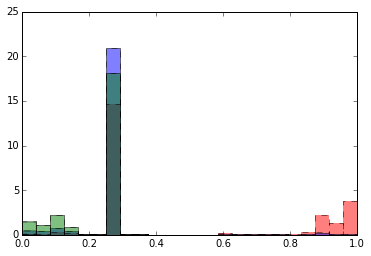

In [10]:
plt.hist(ypred1, bins=np.linspace(0,1,25), normed=True, alpha=0.5, color="red", lw=0);
plt.hist(ypred2, bins=np.linspace(0,1,25), normed=True, alpha=0.5);
plt.hist(ypred3, bins=np.linspace(0,1,25), normed=True, alpha=0.5);

plt.hist(ypred1tr, bins=np.linspace(0,1,25), normed=True, alpha=0.5, color="red", fill=False, lw=1, ls="dashed");
plt.hist(ypred2tr, bins=np.linspace(0,1,25), normed=True, alpha=0.5, color="green", fill=False, lw=1, ls="dashed");
plt.hist(ypred3tr, bins=np.linspace(0,1,25), normed=True, alpha=0.5, color="blue", fill=False, lw=1, ls="dashed");

#plt.hist(ypred2tr, bins=np.linspace(0,1,25), normed=True, alpha=0.5);
#plt.hist(ypred3tr, bins=np.linspace(0,1,25), normed=True, alpha=0.5);

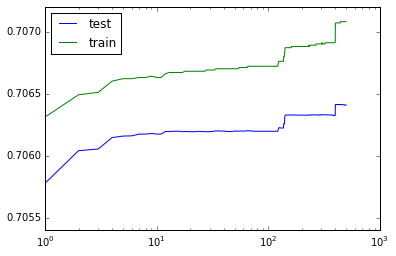

In [11]:
plt.plot(evald["eval"], label="test")
plt.plot(evald["train"], label="train")
plt.legend(loc="best")
plt.xscale("log")